In [49]:
# %%writefile Ind_MFI_VOL.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
# import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class MFI(Ind_Model_Base.Ind_Model):
    """ 资金流动指数 (Money Flow Index)
        
    """
    optimum_param={'valid':False, 'main':'MFI', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'MFI', frequence)
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':14}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        def feature(item_df):
            direct = np.sign(item_df['MFI'] - item_df['MFIMA'])
            ec = af.timeline_event_continuity(direct.fillna(0)).astype(np.float32)
            ec[ec<0] = ec[ec<0] + 0.1 
            return -1 * np.abs(ec)
#             return af.timeline_event_continuity(direct.fillna(0))

        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_MFI_CONTINUITY_NEG_ABS']))
        # NEG_ABS 时防止0干扰
        event_continuity[event_continuity==0] = np.nan
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return None #event_continuity
        
    def kernel(self,dataframe, timeperiod):
#         TP = (HIGH + LOW + CLOSE) / 3    
#         MF = TP * VOLUME       
#         MR = POSITIVE MONEY FLOW / NEGATIVE MONEY FLOW   
#         MFI = 100 - (100 / (1 + MR)         
        if len(dataframe)<=timeperiod:
            return None
        
        tp = (dataframe.close + dataframe.low + dataframe.high)/3
        mf = tp * dataframe.volume * np.sign(tp.diff())
        mf = mf.rolling(timeperiod).apply(lambda x: x[x>=0].sum()/(np.abs(x[x<0].sum())+1))
        mf = 100 - (100 / (1 + mf))
        mf.name = "MFI"
#         mf = (mf-mf.mean())/mf.std()
        ma = talib.MA(mf, timeperiod)
        ma.name = 'MFIMA'
        
        df = pd.concat([mf,ma], axis=1)
#         df = pd.DataFrame(mf)
        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


In [54]:
# data = smpl.get_data(['000001'],end='2019-11-29',gap=154).data
tp_ = (data.close + data.low + data.high)/3
mf_ = tp_ * data.volume * np.sign(tp_.diff())

mf_.rolling(14).apply(lambda x: x[x>=0].sum()/np.abs(x[x<0].sum()))

date        code  
2019-04-15  000001         NaN
2019-04-16  000001         NaN
2019-04-17  000001         NaN
2019-04-18  000001         NaN
2019-04-19  000001         NaN
                        ...   
2019-11-25  000001    0.281311
2019-11-26  000001    0.285344
2019-11-27  000001    0.295546
2019-11-28  000001    0.315898
2019-11-29  000001    0.330977
Length: 155, dtype: float64

Wall time: 533 ms


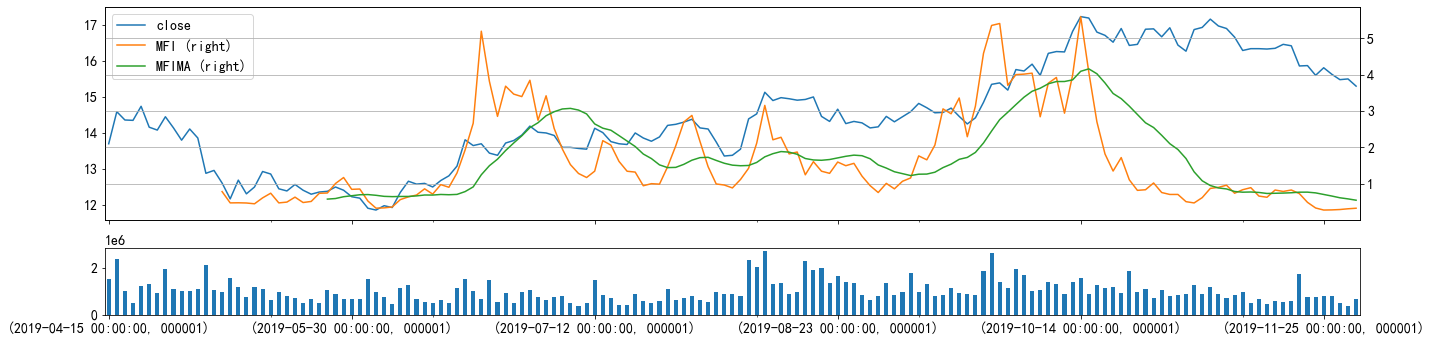

In [34]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import talib
data = smpl.get_data(['000001'],end='2019-11-29',gap=154).data

mfi =MFI(data)
mfi.fit()


fig = plt.figure(figsize=(1620/72,620/72))
ax1= fig.add_subplot(2,1,1)
pd.concat([data.close,mfi.ind_df['MFI'],mfi.ind_df['MFIMA']],axis=1).plot(secondary_y=['MFI','MFIMA'],ax=ax1)
plt.grid()
ax2= fig.add_subplot(6,1,4,sharex=ax1)
data.volume.plot(kind='bar',ax=ax2)
ax2.tick_params(labelbottom=True)  #  解决share后标签不可见的问题。
ax2.xaxis.set_major_locator(ticker.MaxNLocator(6))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2021-11-28


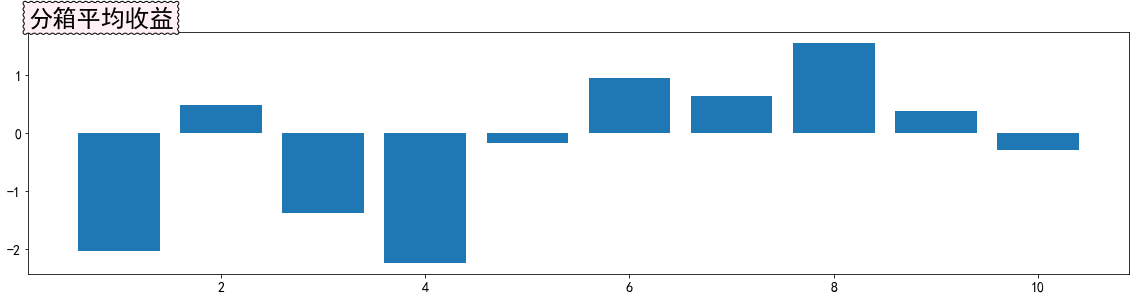

2020-11-28


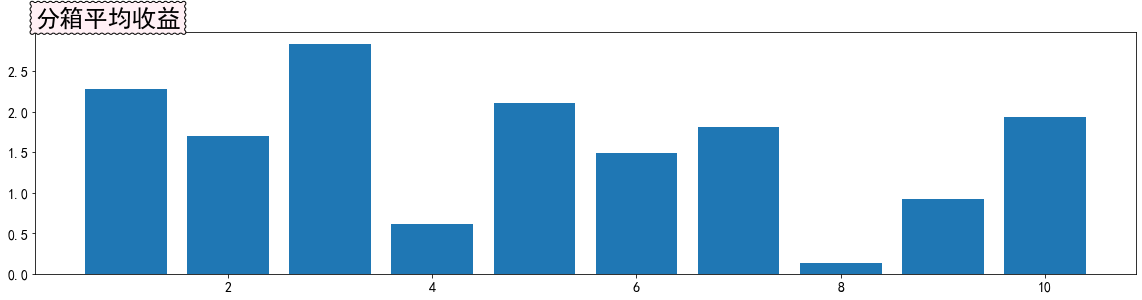

2019-11-28


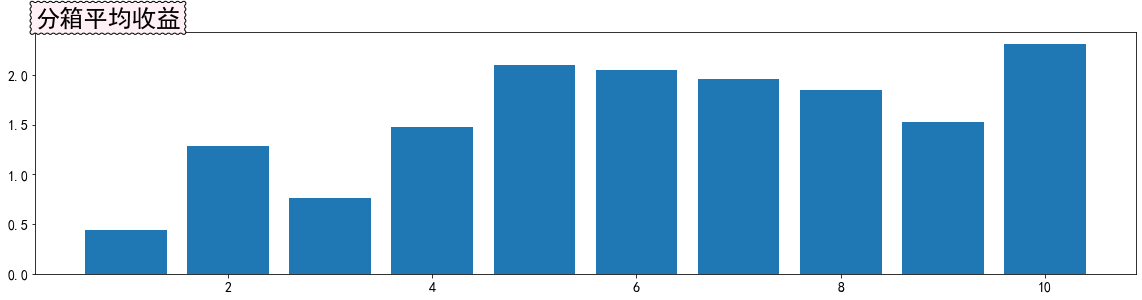

2018-11-28


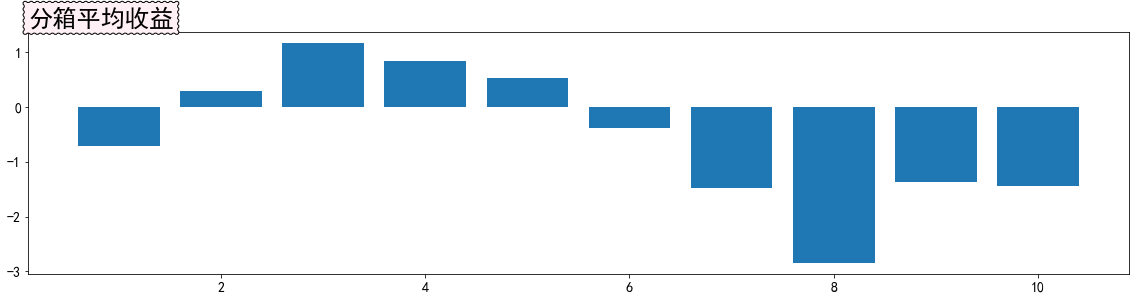

2017-11-28


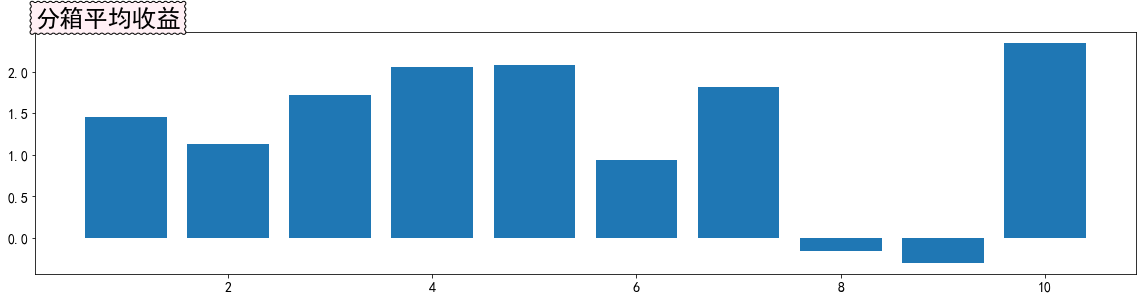

2016-11-28


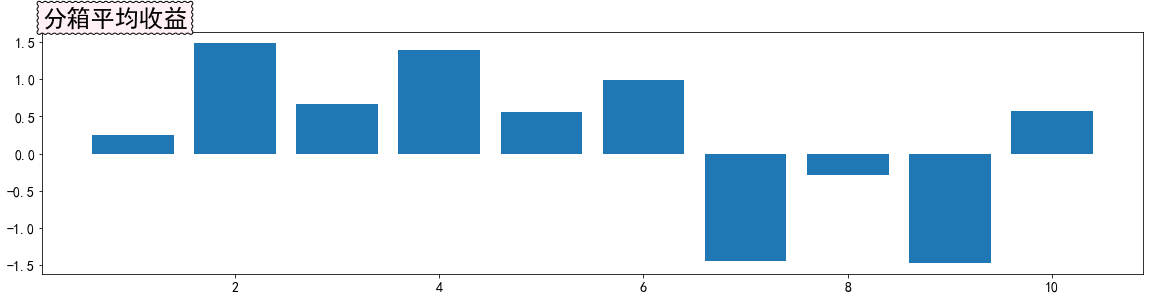

Wall time: 1min 8s


In [40]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2021-11-28']
for date in dates:
    print(date)
    test = FactorTest(MFI, sample='上证50', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':True,'static_mv':False},target_field='MFI')
    test.process()
    test.plot(only_binned=True)


2021-11-28


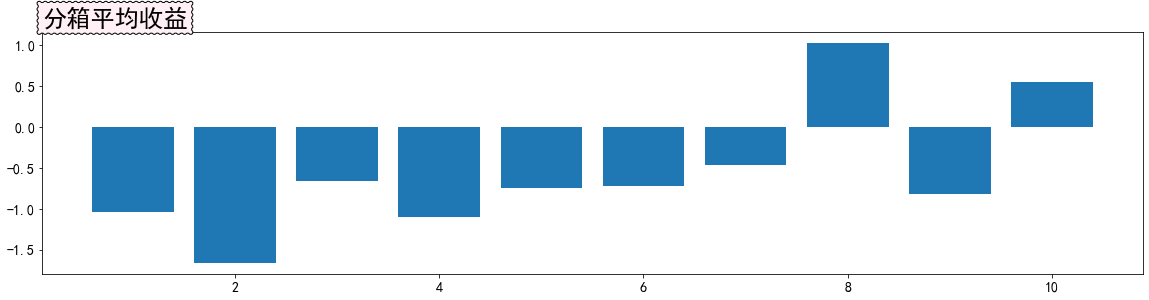

2020-11-28


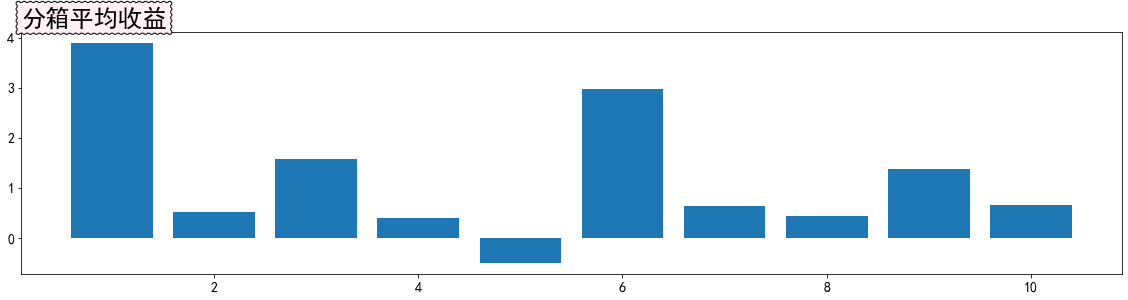

2019-11-28


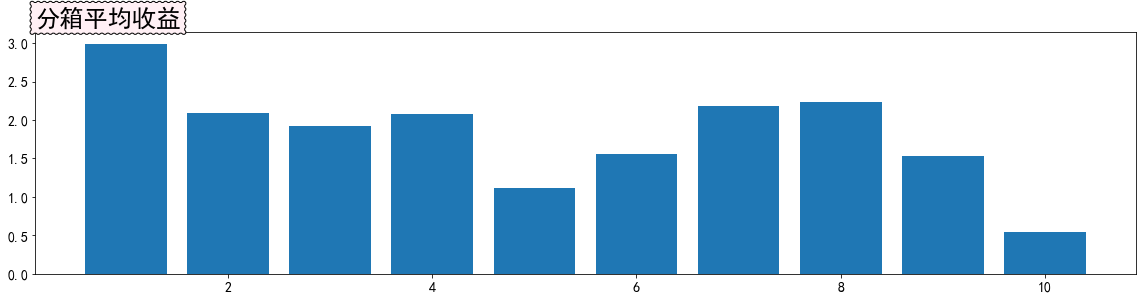

2018-11-28


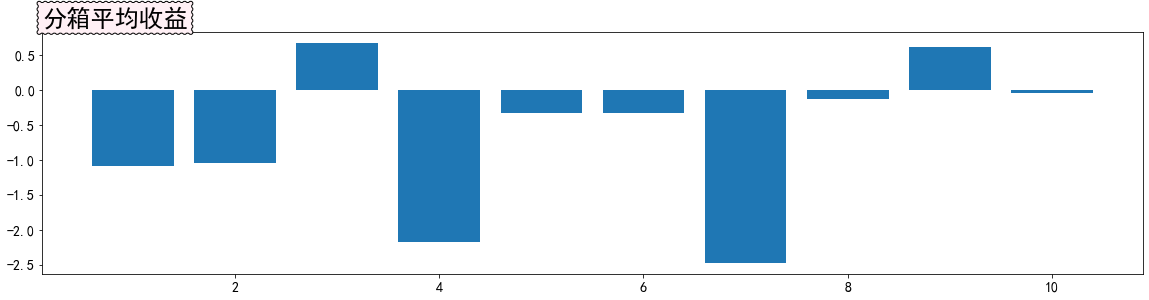

2017-11-28


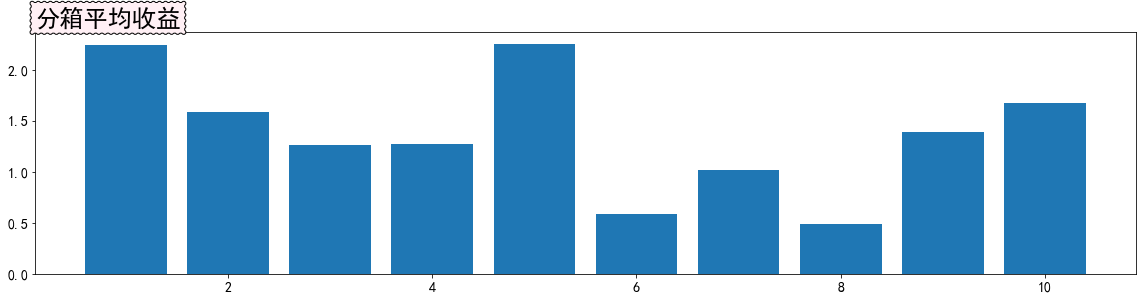

2016-11-28


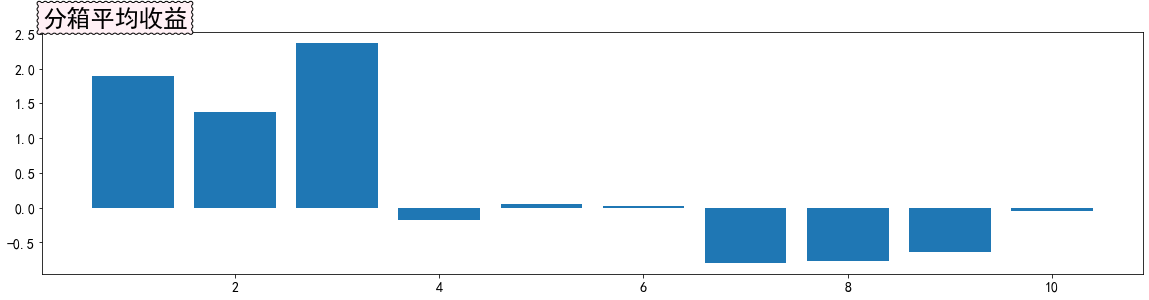

Wall time: 1min 5s


In [50]:
%%time

dates = ['2021-11-28','2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']
# dates = ['2021-11-28']
for date in dates:
    print(date)
    test = FactorTest(MFI, sample='上证50', freq="d",end=date, gap=250, only_main=True, neutralize={'enable':False,'static_mv':False},target_field='feature_MFI_CONTINUITY_NEG_ABS')
    test.process()
    test.plot(only_binned=True)

In [26]:
test.ind_ret_df['MFI']


date        code  
2020-11-20  600000    100.000022
            600009    100.000013
            600016    100.000032
            600028    100.000026
            600030     99.999994
                         ...    
2021-11-25  601995    100.000014
            603259     99.999996
            603288    100.000012
            603501     99.999995
            603986    100.000004
Name: MFI, Length: 12340, dtype: float64